# Sample the voting model

Plot the group rate function and its iterations. Odd/even pairs of values are used.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize
import sociophysics.experiment
import sociophysics.voting
from IPython.display import set_matplotlib_formats

Parameters

In [3]:
outdir = "out/"
plotdir = "plot/"

## Numerical experiment

Parameters

In [4]:
sizes = np.array([3, 4, 5, 6])
maxlevels = np.arange(1, 6)
rates = np.linspace(0, 1, 101)
path = outdir + "voting-model_sample.csv"

Run

In [5]:
model = sociophysics.voting.sample_model
experiment = sociophysics.experiment.Experiment(model)
experiment.run(sizes, maxlevels, rates)
experiment.to_file(path)

## Analysis

Parameters

In [6]:
pathin = outdir + "voting-model_sample_testa2.csv"
pathout = plotdir + "voting-model_plot_testa2.pdf"

Retrieve data 

In [7]:
df_model = pd.read_csv(
    pathin, comment="#",
    index_col=['size', 'maxlevel', 'rate'],
).sort_index()

sizes, maxlevels, rates = df_model.index.levels

df_model['error'] = df_model['mean_approx'] - df_model['mean_exact']

Style

In [8]:
plotstyle = {
    'linestyle': 'None',
    'marker': 'o',
    'markersize': 4,
    'markerfacecolor': 'white',
    'markeredgewidth': 1,
    'markeredgecolor': 'black',
}
plt.style.use(['seaborn-paper', plotdir + ".mplstyle"])
set_matplotlib_formats('pdf', 'svg')
width = 8.3*0.7

Plot

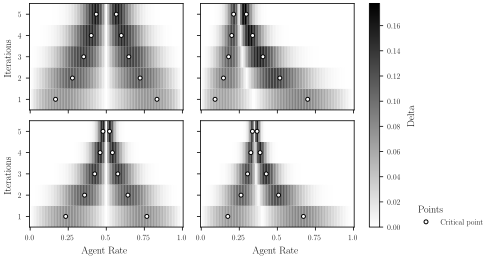

In [9]:
nrows = 2
ncols = 2

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols,
    sharex=True, sharey=True,
    figsize=(width, width / 1.618)
)

vmin = 0
vmax = df_model['error'].max()

semidelta_x = 0.5 / (rates.size-1)
coord_x = np.append(rates, 1 + 2*semidelta_x)
semidelta_y = -0.5
coord_y = np.insert(maxlevels, 0, 0)

for size, ax in zip(sizes, axs.flat):
    coord_z = np.abs(df_model['error'].xs(
        size, level='size').unstack()
    )
    im = ax.pcolormesh(
        coord_x, coord_y, coord_z,
        vmin=vmin, vmax=vmax
    )

    maxbound = 0.5 + 1e-6
    minbound = (5 - np.sqrt(13)) / 6 - 1e-6
    p_c = scipy.optimize.brentq(
        lambda x: sociophysics.voting.grouprate(size, x) - x,
        minbound, maxbound
    )
    diff_p_c = sociophysics.voting.diff_grouprate(size, p_c)
    for i in maxlevels:
        ax.plot(
            p_c*(1-diff_p_c**(-i)) + semidelta_x,
            i + semidelta_y,
            **plotstyle
        )
        ax.plot(
            p_c*(1-diff_p_c**(-i)) + diff_p_c**(-i) + semidelta_x,
            i + semidelta_y,
            **plotstyle
        )

    ax.set_xticks(np.linspace(0, 1, 5) + semidelta_x)
    ax.set_xticklabels(np.linspace(0, 1, 5))
    ax.set_yticks(maxlevels + semidelta_y)
    ax.set_yticklabels(maxlevels)

for i in range(nrows):
    axs[i, 0].set_ylabel("Iterations")
for j in range(ncols):
    axs[-1, j].set_xlabel("Agent Rate")

cb = fig.colorbar(im, ax=axs, aspect=35, pad=0.01)
cb.set_label("Delta")

ax.lines[-1].set_label("Critical point")
legend = fig.legend(
    title="Points",
    loc='lower left',
    bbox_to_anchor=(1, ax.get_position().y0))
legend._legend_box.align = 'left'

fig.savefig(pathout, bbox_extra_artists=(legend,))